Data Analysis Plan
---
Goal: Test multiple models on the relationship between IGT scores & ventral striatal sensitivity between DRD2 carrier groups

- Grab variables of interest
    - P = D.P_payoff
    - Q = D.Q_sensitivity 
    - VS = D.Cards_RNR_VS_mean 
    - AGE = D.AGE
    - SEX = D.female_1
    <br><br>
- Filter to only get subjects who have data for P and VS, and who are white <br><br>
    good=find(~isnan(VS) & ~isnan(P) & D.white(1)<br>
    good_subs = zeros(size(AGE))<br>
    good_subs(good) = 1<br>
    N = length(D.AGE(good))<br>
    <br>
- Separate by DRD2 polymorphism<br><br>
    1 = Del. carrier (low D2) <br>
    0 = Ins/Ins (normal D2) <br>
    drd2_high = find(good_subs & D.DRD2_score==1) <br>
    drd2_low = find(good_subs & D.DRD2_score==0) <br>
    <br>
---

Analysis pipeline:

1. Demographic summary of groups:
    - Age
    - Sex
    - N (number in each group)
<br><br>
2. Group (DRD2 group) differences in:
    - VS
    - P
    - Q
    
         a.) visualize in graph <br>
         b.) analyze with t-test
<br><br>
3. Separate P vs. VS regressions for each group
    - Control for: Age & sex?


Dependencies

In [31]:
import csv
import numpy as np
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sb
from scipy import stats
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
import ptitprince as pt

from statsmodels.compat import unicode
import statsmodels.api as sm

#import plotly.plotly as py
#import plotly.express as px

pd.set_option('display.max_columns', 8)

Demographic summary

In [12]:
data = pd.read_csv('DRD2_subset_data.csv', delimiter=',')
data = data.dropna(subset=['P','Q','VS','DRD2', 'AGE', 'female_1'])
data

,AGE,female_1,P,Q,VS,Obesity,DRD2,LABID
1,49,1,-4.0,12.0,-0.099976,1.283069,0.0,30390
2,35,1,44.0,62.0,0.334085,-1.102770,0.0,30407
3,45,1,18.0,36.0,0.532905,0.619251,1.0,30435
4,30,1,52.0,10.0,0.164745,-0.433993,0.0,30437
5,33,1,-22.0,50.0,-0.031081,-1.746404,0.0,30465
6,40,1,12.0,30.0,0.309690,-1.187490,0.0,30487
7,35,1,54.0,48.0,-0.022202,0.051571,0.0,30634
9,40,0,6.0,38.0,0.026168,-0.376368,0.0,30711
11,38,1,4.0,40.0,-0.078070,1.256917,1.0,30961
12,31,0,-14.0,12.0,0.114475,-0.188889,0.0,30966


# Age

AGE Summary: count    438.000000
mean      42.666667
std        7.370442
min       30.000000
25%       36.000000
50%       43.500000
75%       49.000000
max       54.000000
Name: AGE, dtype: float64


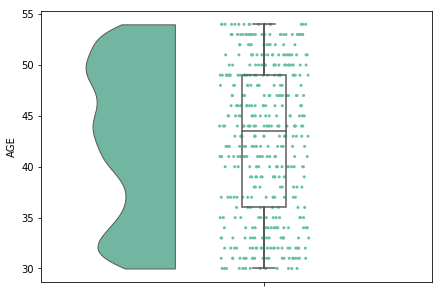

In [13]:
age_summary = data.AGE.describe()
print('AGE Summary:', age_summary)
#AGE_violin = sb.violinplot(y='AGE', data=data, palette='Blues')
AGE_raincloud = pt.RainCloud(y='AGE', data=data, width_viol=.4, width_box=.1, figsize=(7,5))

# Sex

Sex Summary: count    438.000000
mean       0.520548
std        0.500149
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: female_1, dtype: float64


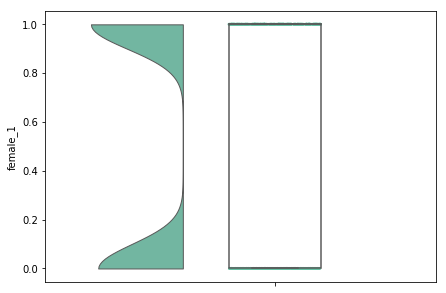

In [14]:
sex_summary = data.female_1.describe()
print('Sex Summary:', sex_summary)
#SEX_violin = sb.violinplot(y='female_1', data=data, palette='Blues')
SEX_raincloud = pt.RainCloud(y='female_1', data=data, width_viol=.4, width_box=.2, figsize=(7,5))

# IGT Scores

IGT Measures Summary 

 P 
 count    438.000000
mean      16.369863
std       29.908177
min      -92.000000
25%       -4.000000
50%       14.000000
75%       40.000000
max       96.000000
Name: P, dtype: float64 

 Q 
 count    438.000000
mean      31.616438
std       25.414800
min      -46.000000
25%       16.000000
50%       38.000000
75%       48.000000
max       86.000000
Name: Q, dtype: float64


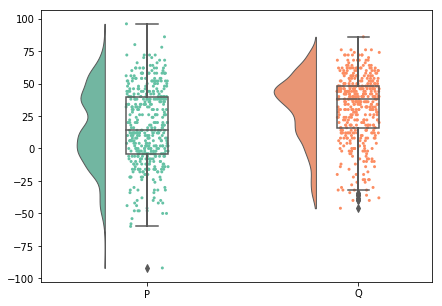

In [15]:
P_summary = data.P.describe()
Q_summary = data.Q.describe()
print('IGT Measures Summary','\n\n','P','\n', P_summary, '\n\n','Q','\n', Q_summary)
#IGT_violin = sb.violinplot(data=data.iloc[:,2:4], palette='Blues')
IGT_raincloud = pt.RainCloud(data=data.iloc[:,2:4], width_viol=.4, width_box=.2, figsize=(7,5))


# VS 

VS Summary 

 count    438.000000
mean       0.107567
std        0.166886
min       -0.543820
25%        0.008345
50%        0.099525
75%        0.204464
max        0.851100
Name: VS, dtype: float64


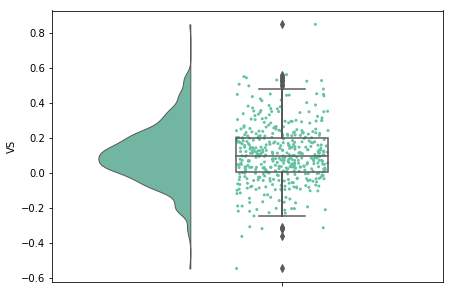

In [16]:
VS_summary = data.VS.describe()
#Ob_summary = data.Obesity.describe()
print('VS Summary', '\n\n', VS_summary)
#print('Obesity Summary', '\n\n', Ob_summary)
#VS_Ob_violin = sb.violinplot(y='VS', data=data, palette='Blues')
VS_raincloud = pt.RainCloud(y='VS', data=data, width_viol=.4, width_box=.2, figsize=(7,5))

# DRD2

DRD2 Carrier Summary: count    438.000000
mean       0.271689
std        0.445339
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: DRD2, dtype: float64


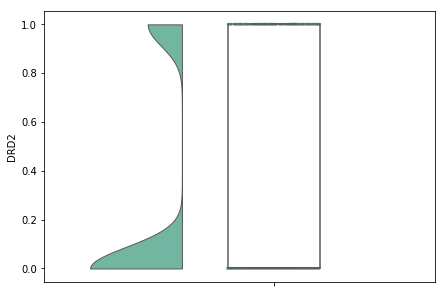

In [17]:
DRD2_summary = data.DRD2.describe()
print('DRD2 Carrier Summary:', DRD2_summary)
#DRD2_violin = sb.violinplot(y='DRD2', data=data, palette='Blues')
DRD2_raincloud = pt.RainCloud(y='DRD2', data=data, width_viol=.4, width_box=.2, figsize=(7,5))

If DRD2 == 1, subjects are DRD2 deletion carriers --> low D2 receptors --> Abnormal

If DRD2 == 0, subjects are DRD2 insertion carriers --> normal D2 receptors --> Control

In [18]:
abnormal = data[data['DRD2'] == 1] #"High DA"
control = data[data['DRD2'] == 0] #"Low DA"

# T-test
Standard Independent 2 sample test that assumes equal population variance

In [19]:
t_test_results = stats.ttest_ind(abnormal.iloc[:,2:5], control.iloc[:,2:5], equal_var=True)
t_test_results

# P, Q, VS

Ttest_indResult(statistic=array([-3.23083657,  0.53904942, -1.77172964]), pvalue=array([ 0.00132777,  0.59012789,  0.07713785]))

Welch's Test which does not assume equal population variance

In [20]:
stats.ttest_ind(abnormal.iloc[:,2:5], control.iloc[:,2:5], equal_var=False)

# P, Q, VS

Ttest_indResult(statistic=array([-3.2966212 ,  0.56431476, -1.7465982 ]), pvalue=array([ 0.00114068,  0.57308456,  0.08219884]))

### Scatter Plot for T-tests

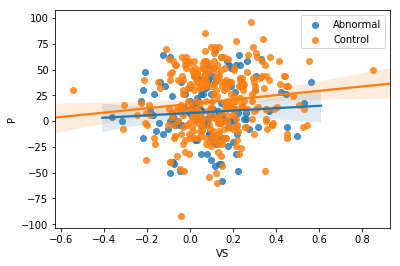

In [21]:
scatter_P_abnormal = sb.regplot(x='VS', y='P', data=abnormal, label='Abnormal').legend()
scatter_P_control = sb.regplot(x='VS', y='P', data=control, label='Control').legend()

In [56]:
#scatter_AGE_abnormal = sb.regplot(x='AGE', y='P', data=abnormal, label='Abnormal').legend()
#scatter_AGE_abnormal = sb.regplot(x='AGE', y='P', data=control, label='Control').legend()

In [57]:
#scatter_Female_abnormal = sb.regplot(x='female_1', y='P', data=abnormal, label='Abnormal').legend()
#scatter_Female_abnormal = sb.regplot(x='female_1', y='P', data=control, label='Control').legend()

# Histograms

### P Score between abnormal and control DRD2 groups

P Score T-test between abnormal and control DRD2 groups


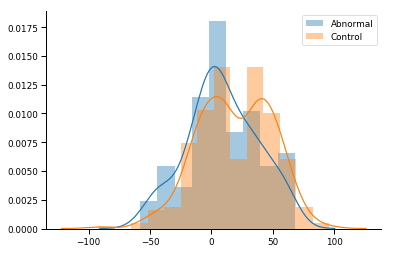

In [22]:
sb.set_context("paper")

abnormal_P_data = pd.concat([abnormal['P']], axis=1)
control_P_data = pd.concat([control['P']], axis=1)


print("P Score T-test between abnormal and control DRD2 groups")
hist_P_abnormal = sb.distplot(abnormal_P_data, label='Abnormal')
hist_P_control = sb.distplot(control_P_data, label='Control')

plt.legend();

sb.despine()

### Q Score T-test between abnormal and control DRD2 groups

Q Score T-test between high and low DA groups


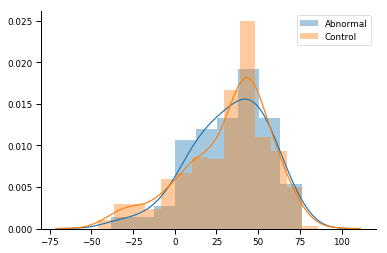

In [23]:
sb.set_context("paper")

abnormal_Q_data = pd.concat([abnormal['Q']], axis=1)
control_Q_data = pd.concat([control['Q']], axis=1)


print("Q Score T-test between high and low DA groups")
hist_Q_abnormal = sb.distplot(abnormal_Q_data, label='Abnormal')
hist_Q_control = sb.distplot(control_Q_data, label='Control')



plt.legend();


sb.despine()

### VS between abnormal and control DRD2 groups

VS T-test between abnormal and control DRD2 groups


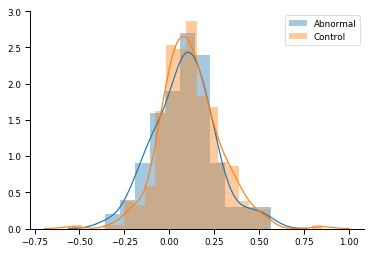

In [24]:
sb.set_context("paper")

abnormal_VS_data = pd.concat([abnormal['VS']], axis=1)
control_VS_data = pd.concat([control['VS']], axis=1)


print("VS T-test between abnormal and control DRD2 groups")
scatter_VS_abnormal = sb.distplot(abnormal_VS_data, label='Abnormal')
scatter_VS_control = sb.distplot(control_VS_data, label='Control')
plt.legend();


sb.despine()

# Linear Regressions

### High DA: P vs VS

In [48]:
target = pd.DataFrame(abnormal.P, columns=['P'])
x = pd.DataFrame(abnormal, columns=['VS', 'AGE', 'female_1'])
y = target['P']

interaction = PolynomialFeatures(include_bias=False, interaction_only=True)
x_inter = interaction.fit_transform(x)

lm = linear_model.LinearRegression()
model = lm.fit(x_inter,y)

abnormal_predictions = lm.predict(x_inter)

print('score:', lm.score(x_inter,y))
print('coefficients:', lm.coef_)
print('intercept:', lm.intercept_)


score: 0.0731980103916
coefficients: [ 23.11394404  -0.46533512 -27.32259897  -0.6312675   39.37238932
   0.30499155]
intercept: 34.5906075612


In [26]:
results = sm.OLS(y,x).fit()

print("DRD2==1")
print(results.summary())

DRD2==1
                                 OLS Regression Results                                
Dep. Variable:                      P   R-squared (uncentered):                   0.112
Model:                            OLS   Adj. R-squared (uncentered):              0.089
Method:                 Least Squares   F-statistic:                              4.886
Date:                Mon, 14 Oct 2019   Prob (F-statistic):                     0.00310
Time:                        13:26:47   Log-Likelihood:                         -566.03
No. Observations:                 119   AIC:                                      1138.
Df Residuals:                     116   BIC:                                      1146.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

### Control: P vs VS

In [47]:
target = pd.DataFrame(control.P, columns=['P'])
x = pd.DataFrame(control, columns=['VS', 'AGE', 'female_1'])
y = target['P']

interaction = PolynomialFeatures(include_bias=False, interaction_only=True)
x_inter = interaction.fit_transform(x)

lm = linear_model.LinearRegression()
model = lm.fit(x_inter,y)

control_predictions = lm.predict(x_inter)
#print(predictions)

print('Y = AX1 + BX2 + CX3 + DX1*X2 + EX2*X3 + FX3*X1')
print('\nX1 = VS \nX2 = AGE \nX3 = Female \n')
#print('score:', lm.score(x_inter,y))
print(lm.coef_)
print('intercept:', lm.intercept_)


Y = AX1 + BX2 + CX3 + DX1*X2 + EX2*X3 + FX3*X1

X1 = VS 
X2 = AGE 
X3 = Female 

[-66.66337194  -0.18631062   4.38422254   1.48928417  39.2862483
  -0.41942398]
intercept: 32.4014164537


In [28]:
results = sm.OLS(y,x).fit()
results.params
print("DRD2==0")
print(results.summary())

DRD2==0
                                 OLS Regression Results                                
Dep. Variable:                      P   R-squared (uncentered):                   0.298
Model:                            OLS   Adj. R-squared (uncentered):              0.291
Method:                 Least Squares   F-statistic:                              44.66
Date:                Mon, 14 Oct 2019   Prob (F-statistic):                    4.35e-24
Time:                        13:26:47   Log-Likelihood:                         -1535.0
No. Observations:                 319   AIC:                                      3076.
Df Residuals:                     316   BIC:                                      3087.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------